# 현재 시작 27일 11시 42분, 지금까지 작업하던거 run이 안돼 재로그인했다가 싹 다 날아갔습니다 ㅋㅋ 억울합니다
# 다 잘되던게 다시 하니 오류 투성이네요 ㅋㅋ 코딩의 세계란..ㅋ

# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

## <목차>

1. 데이터 준비와 확인
2. 데이터로더 구성
3. 모델 구성을 위한 데이터 분석 및 가공
4. 모델 구성 및 validation set 구성
5. 모델 훈련 개시
6. Loss, Accuracy 그래프 시각화
7. 학습된 Embedding 레이어 분석
8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

   

# 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models import KeyedVectors
from konlpy.tag import Mecab

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    train_data = train_data.dropna(how = 'any')  # NA값 제거
    
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    test_data = test_data.dropna(how = 'any')  # NA값 제거 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 딕셔너리에 {텍스트:인덱스} 구조로 저장
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print("train: {}, test: {}".format(len(X_train), len(X_test)))

train: 146182, test: 49157


In [3]:
# {텍스트: 인덱스}에서 {인덱스:텍스트}로 변경

index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공
- padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느 쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생
- 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적이기 때문에 'pre'가 훨씬 유리

In [5]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 지정 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [7]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

# 4. 모델 구성 및 validation set 구성

In [34]:
# validation set 10000건 분리
x_val = X_train[:10000]
y_val = y_train[:10000]

partial_x_train = X_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [54]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 4  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

## (1) 1-D CNN

In [47]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(keras.layers.MaxPooling1D(5))
model1.add(keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 4)           40000     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 16)          464       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

## (2) LSTM

In [51]:
model2 = keras.Sequential(name='LSTM')
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(8))
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 4)           40000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 416       
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


## (3) GlobalMaxPooling1D

In [55]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model3.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 4)                 0         
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


# 5. 모델 훈련 개시
## (1) 1-D CNN
- epochs 5 이후로 과접합이 일어나 val_accuracy가 낮아진다.

In [48]:
model1.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model1.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
266/266 [==============================] - 2s 5ms/step - loss: 0.5839 - accuracy: 0.7019 - val_loss: 0.4811 - val_accuracy: 0.8380
Epoch 2/5
266/266 [==============================] - 1s 4ms/step - loss: 0.4491 - accuracy: 0.8476 - val_loss: 0.4372 - val_accuracy: 0.8467
Epoch 3/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3445 - accuracy: 0.8637 - val_loss: 0.3394 - val_accuracy: 0.8531
Epoch 4/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3067 - accuracy: 0.8736 - val_loss: 0.3374 - val_accuracy: 0.8538
Epoch 5/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2919 - accuracy: 0.8801 - val_loss: 0.3376 - val_accuracy: 0.8538


## (2) LSTM

In [52]:
model2.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=7

history = model1.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/7
266/266 [==============================] - 1s 4ms/step - loss: 0.2796 - accuracy: 0.8868 - val_loss: 0.3392 - val_accuracy: 0.8538
Epoch 2/7
266/266 [==============================] - 1s 4ms/step - loss: 0.2694 - accuracy: 0.8917 - val_loss: 0.3442 - val_accuracy: 0.8531
Epoch 3/7
266/266 [==============================] - 1s 4ms/step - loss: 0.2590 - accuracy: 0.8966 - val_loss: 0.3519 - val_accuracy: 0.8531
Epoch 4/7
266/266 [==============================] - 1s 4ms/step - loss: 0.2499 - accuracy: 0.9016 - val_loss: 0.3641 - val_accuracy: 0.8500
Epoch 5/7
266/266 [==============================] - 1s 4ms/step - loss: 0.2408 - accuracy: 0.9063 - val_loss: 0.3715 - val_accuracy: 0.8493
Epoch 6/7
266/266 [==============================] - 1s 4ms/step - loss: 0.2323 - accuracy: 0.9105 - val_loss: 0.3790 - val_accuracy: 0.8461
Epoch 7/7
266/266 [==============================] - 1s 4ms/step - loss: 0.2238 - accuracy: 0.9144 - val_loss: 0.3900 - val_accuracy: 0.8444


## (3) GlobalMaxPooling1D

In [56]:
model3.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = model1.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2164 - accuracy: 0.9190 - val_loss: 0.3989 - val_accuracy: 0.8405
Epoch 2/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2091 - accuracy: 0.9225 - val_loss: 0.4117 - val_accuracy: 0.8432
Epoch 3/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2031 - accuracy: 0.9252 - val_loss: 0.4255 - val_accuracy: 0.8437
Epoch 4/10
266/266 [==============================] - 1s 4ms/step - loss: 0.1976 - accuracy: 0.9280 - val_loss: 0.4405 - val_accuracy: 0.8367
Epoch 5/10
266/266 [==============================] - 1s 4ms/step - loss: 0.1916 - accuracy: 0.9310 - val_loss: 0.4474 - val_accuracy: 0.8372
Epoch 6/10
266/266 [==============================] - 1s 4ms/step - loss: 0.1867 - accuracy: 0.9335 - val_loss: 0.4613 - val_accuracy: 0.8362
Epoch 7/10
266/266 [==============================] - 1s 4ms/step - loss: 0.1822 - accuracy: 0.9354 - val_loss: 0.4701 - val_accuracy: 0.8359
Epoch 

# 6. Loss, Accuracy 그래프 시각화
## (1) 1-D CNN

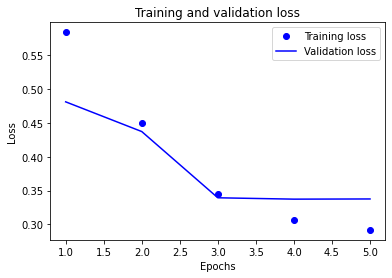

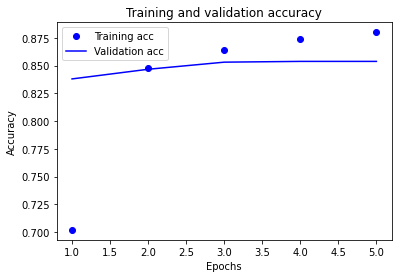

In [49]:
history_dict = history.history

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (2) LSTM

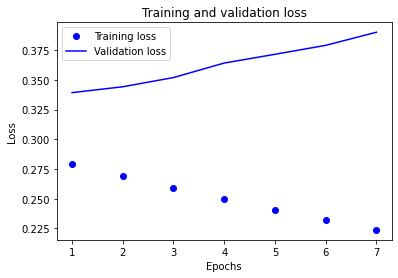

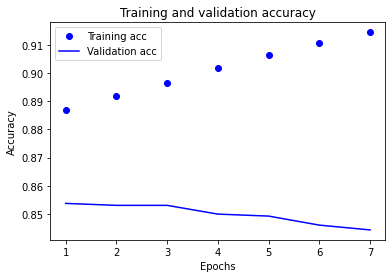

In [53]:
history_dict = history.history

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (3) GlobalMaxPooling1D

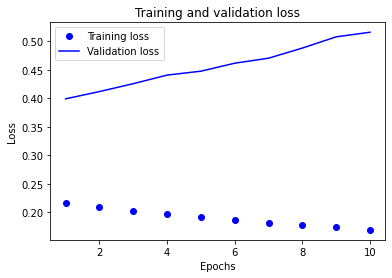

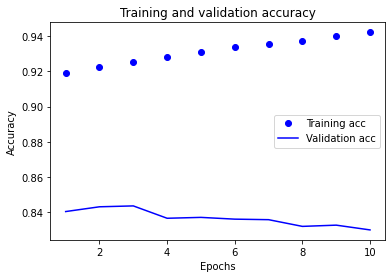

In [57]:
history_dict = history.history

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7. 학습된 Embedding 레이어 분석

In [58]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 4)


In [60]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [61]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['명작']
vector

array([-0.01807852, -0.20211808, -0.14292519, -0.21055554], dtype=float32)

In [62]:
word_vectors.similar_by_word("명작")

[('출', 0.9985035061836243),
 ('곽', 0.9984423518180847),
 ('쿠바', 0.997645914554596),
 ('뺐', 0.9968776702880859),
 ('꼬맹이', 0.9967271089553833),
 ('미칠', 0.9963586330413818),
 ('베스트', 0.9962886571884155),
 ('비롯', 0.9952020645141602),
 ('진솔', 0.9950496554374695),
 ('내년', 0.9933837056159973)]

In [63]:
word_vectors.similar_by_word("최악")

[('선조', 0.9998329281806946),
 ('디워', 0.9993906617164612),
 ('조잡', 0.9983333349227905),
 ('1970', 0.9981253743171692),
 ('얼간', 0.9974958896636963),
 ('불만', 0.9969884157180786),
 ('오광록', 0.9966535568237305),
 ('나잇', 0.995598316192627),
 ('센터', 0.995398759841919),
 ('김대희', 0.9953517913818359)]

# 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선
- gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.

In [64]:
import gensim
gensim.__version__

'4.1.2'

In [ ]:
! pip uninstall gensim
! pip install gensim==3.4.0 --yes 

In [ ]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
#word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['명작']
vector     # 무려 300dim의 워드 벡터입니다.

# 9. 회고
### <이번 프로젝트에서 어려웠던 점>
근 5일동안 exploration 5만 붙잡느라 정신적 에너지를 많이 소모해 exploratioon6에 손대기까지 시간이 오래 걸렸다.   
그래도 막상 하니 재미는 있었다. 5에 비해서는 조금 쉬운 것 같아서 다행이었다.   
어쩐지 너무 순조롭게 잘 되더라. 제출 20분 전에 재로그인하고 파일이 싹 날아갔다 ㅋㅋ   
처음엔 괜찮았는데 다시 하면서 없었던 오류가 나기 시작하니 화가 났다.  
이게 젤 어려웠던 점이다.   

### <프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점>
(1) 주피터 노트북   
주피터 노트북을 처음 사용해보는데, colab에 비하면 상당히 불편하다는 점.   
intall을 해줄 때 y를 입력하거나 -y로는 옵션이 먹히지 않는 다는 점.   
따라서 intall y/n 처리를 해주기 위해서는 아래 방법 중 선택해야 한다.   
- echo "y" | !pip install [설치하고자 하는 패키지명] # []는 제외하고 패키지 이름만 쓸 것
- !pip install [설치하고자 하는 패키지명] --yes # []는 제외하고 패키지 이름만 쓸 것


(2) PAD
처음에 할 때는 tokenizer 상에서 PAD 해준게 먹히지 않았다.   
그래서 따로 설정해줬는데 새롭게 다시 하니까 되네...?   
분명 할 때마다 같은 조건으로 RUN 해주는데 왜 자꾸 결과물과 오류는 달라지는지 알 수가 없는 일이다.



### <루브릭 평가 지표를 맞추기 위해 시도한 것들>
word_vector_dim 파라미터와 epochs를 조절해 85% 이상을 얻으려고 노력했다.   


### <만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정>
없음


### <자기 다짐>
적당히 하자... 적당히

## 10. Reference
1. 주피터 노트북 install : https://vg-rlo.tistory.com/134 [vg-rlo]